# MOGPs for Dose Response Predictions and Features Relevance Determination
## In this notebook:
1. We train the MOGP model using the GDSC2 dataset and compute a features ranking via KL-Relevance method.
2. Compute features ranking using SHAP (SHapley Additive exPlanations) and load ANOVA raking.
3. We generate a figure to compare rankings obtained with KL-Relevance, SHAP and ANOVA.

## Experiments for GDSC2 Dataset
This section to train the MOGP model on GDSC2 dataset can be run without depending on having run the previous section on GDSC1.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt


_FOLDER = "./Dataset_BRAF_NoReplica_ANOVA_Features/GDSC2/"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import getopt
import sys
sys.path.append('..')

warnings.filterwarnings("ignore")

In [2]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"In this cell we can configure different initalisation values for training the MOGP model"
"We mainly trained for the three drugs: 1036 (PLX-4720), 1061 (SB590885) and 1373 (Dabrafenib)"
"By default the config.Train = False, so as per the drug the following cell will load the models"
"already trained, if config.Train = True then the MOGP will train along all K-fold with the initial values"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
class commandLine:
    def __init__(self):
        "TODO: make N_iter work when training!!!"
        self.N_iter = 30    #number of iterations
        self.which_seed = 1016    #change seed to initialise the hyper-parameters
        self.rank = 2
        self.scale = 1
        self.weight = 0.01
        self.bash = "547"
        self.drug_name = "1373"
        self.Train = False  #Switch to False if just want the load the already trained model

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
config = commandLine()
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"dictionary to map drug_id to drug_name"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
dict_drug_name = {1036:'PLX-4720',1061:'SB590885',1373:'Dabrafenib'}

In [3]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Default configurations to load the already trained MOGP models"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
if config.drug_name == '1036' and config.Train == False:
    config.N_iter = 30;config.which_seed = 1016;config.rank = 2;config.scale = 1.0
    config.weight = 0.01;config.bash = "547";config.drug_name = "1036"
elif config.drug_name == '1061' and config.Train == False:
    config.N_iter = 30;config.which_seed = 1019;config.rank = 5;config.scale = 3.0
    config.weight = 1.0;config.bash = "837";config.drug_name = "1061"
elif config.drug_name == '1373' and config.Train == False:
    config.N_iter = 30;config.which_seed = 1015;config.rank = 2;config.scale = 3.0
    config.weight = 0.01;config.bash = "484";config.drug_name = "1373"

In [4]:
"#Bear in mind that in GDSC2 dataset all drugs have 7 concentrations, i.e., d1, d2, d3, d4, d5, d6, d7"

name_for_KLrelevance = 'GDSC2_melanoma_BRAF_noreps_v3.csv'
name_ANOVA_feat_file = "GDSC2_BRAFmelanoma_ANOVA_features.csv"

df_train_No_MolecForm = pd.read_csv(_FOLDER + name_for_KLrelevance)  # Contain Train dataset prepared by Subhashini-Evelyn
df_ANOVA_feat_Names = pd.read_csv(_FOLDER + name_ANOVA_feat_file)  # Contain Feature Names used by ANOVA
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
df_train_No_MolecForm = df_train_No_MolecForm[(df_train_No_MolecForm["DRUG_ID"]==int(config.drug_name))]
try:
    df_train_No_MolecForm = df_train_No_MolecForm.drop(columns='Drug_Name')
except:
    pass

Dnorm_cell = 7   # This variable equals 7 since for all GDSC2 we have 7 drug concentrations
# Here we just check that from the column index 25 the input features start
start_pos_features = 25
print(df_train_No_MolecForm.columns[start_pos_features])

ARID1A_mut


In [5]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Scale the Genomic features to be between 0 and 1"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
scaler = MinMaxScaler().fit(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
X_train_features = scaler.transform(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we extract from the dataframe the D outputs related to each dose concentration"
"Below we select 7 concentration since GDSC2 has that number for all Drugs"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
y_train_drug = np.clip(df_train_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
print(y_train_drug.shape)
for i in range(2, 8):
    y_train_drug = np.concatenate(
        (y_train_drug, np.clip(df_train_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)

print("Ytrain size: ", y_train_drug.shape)

(47, 1)
Ytrain size:  (47, 7)


In [6]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Since we fitted the dose response curves with a Sigmoid4_parameters function"
"We extract the optimal coefficients in order to reproduce such a Sigmoid4_parameters fitting"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
params_4_sig_train = df_train_No_MolecForm["param_" + str(1)].values[:, None]
for i in range(2, 5):
    params_4_sig_train = np.concatenate((params_4_sig_train, df_train_No_MolecForm["param_" + str(i)].values[:, None]), 1)

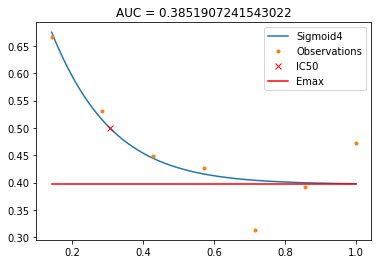

In [7]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"In this sections we will extract the summary metrics AUC, Emax and IC50 from the Sigmoid4_parameters functions"
"These metrics are used as the references to compute the error metrics"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn import metrics
from importlib import reload
import Utils_SummaryMetrics_KLRelevance
import Utils_SummaryMetrics_KLRelevance as MyUtils
reload(MyUtils)

"Bear in mind that x starts from 0.142857143 for 7 drug concentrations in GDSC2 dataset"
"but x starts from 0.111111 for the case of 9 drug concentrations in GDSC1 dataset"
"The function Get_IC50_AUC_Emax is implemented in Utils_SummaryMetrics_KLRelevance.py to extract the summary metrics"
x_lin = np.linspace(0.142857143, 1, 1000)
x_real_dose = np.linspace(0.142857143, 1, 7)  #Here is 7 due to using GDSC2 that has 7 doses
Ydose50,Ydose_res,IC50,AUC,Emax = MyUtils.Get_IC50_AUC_Emax(params_4_sig_train,x_lin,x_real_dose)

def my_plot(posy,fig_num,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug):
    plt.figure(fig_num)
    plt.plot(x_lin, Ydose_res[posy])
    plt.plot(x_real_dose, y_train_drug[posy, :], '.')
    plt.plot(IC50[posy], Ydose50[posy], 'rx')
    plt.plot(x_lin, np.ones_like(x_lin)*Emax[posy], 'r') #Plot a horizontal line as Emax
    plt.title(f"AUC = {AUC[posy]}")
    plt.legend(['Sigmoid4','Observations','IC50','Emax'])

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we can visualise the values of the GDSC2 dataset with the fitting of Sigmoid4_parameters function"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
posy = 0   #select the location you want to plot, do not exceed the Ytrain length
my_plot(posy,0,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug)

In [8]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Organize summary metrics with proper dimensionality"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
AUC = np.array(AUC)
IC50 = np.array(IC50)
Emax = np.array(Emax)

"Below we select just the columns with std higher than zero"
Name_Features_Melanoma = df_train_No_MolecForm.columns[start_pos_features:]
Xall = X_train_features.copy()
Yall = y_train_drug.copy()

print("Sanity check to the same features Evelyin Provided")
print(df_ANOVA_feat_Names["feature"].values[start_pos_features:]==Name_Features_Melanoma)

AUC_all = AUC[:, None].copy()
IC50_all = IC50[:, None].copy()
Emax_all = Emax[:, None].copy()

print("AUC train size:", AUC_all.shape)
print("IC50 train size:", IC50_all.shape)
print("Emax train size:", Emax_all.shape)
print("X all data size:", Xall.shape)
print("Y all data size:", Yall.shape)

Sanity check to the same features Evelyin Provided
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
AUC train size: (47, 1)
IC50 train size: (47, 1)
Emax train size: (47, 1)
X all data size: (47, 24)
Y all data size: (47, 7)


In [9]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a K-fold for cross-validation"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn.model_selection import KFold, cross_val_score
Ndata = Xall.shape[0]
Xind = np.arange(Ndata)
nsplits = 20 #Ndata
k_fold = KFold(n_splits=nsplits)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

'\n'

In [10]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"MOGP model Training process"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
NegMLL_AllFolds = []
Emax_abs_AllFolds = []
AUC_abs_AllFolds = []
IC50_MSE_AllFolds = []
Med_MSE_AllFolds = []
AllPred_MSE_AllFolds = []
Mean_MSE_AllFolds = []
All_Models = []
Ntasks = Dnorm_cell
list_folds = list(k_fold.split(Xall))
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"The for loop below runs K-folds cross-validation process for the MOGP model"
"It is important to highlight that the multiple initializations to select the best model"
"were performed through multiple seeds in a High Performance Computing (HPC) system"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
for Nfold in range(0,nsplits+1):
    model = []
    "The first if below is for the cross-val"
    "Then the else is for using all data to save the model trained over all data"
    Xtrain,Ytrain,Xval,Xval_aux,Yval,Emax_val,IC50_val,AUC_val=MyUtils.ArrangeData_to_CrossVal(Ntasks,Nfold,nsplits,list_folds,Xall,Yall,Emax_all,IC50_all,AUC_all)
    
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    import GPy
    # os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    mean_all = np.zeros_like(Yval)
    models_outs = []

    rank = int(config.rank)  # Rank for the MultitaskKernel
    "Below we substract one due to being the label associated to the output"
    Dim = Xtrain.shape[1]-1
    myseed = int(config.which_seed)
    np.random.seed(myseed)
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Product Kernels. Below we use the locations:"
    "Kernel1 accounts for locations 0:11 for Mutation"
    "Kernel2 accounts for locations 11:end for PANCAN"
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    split_dim = 2
    AddKern_loc = [11, Dim]
    mykern = GPy.kern.RBF(AddKern_loc[0], active_dims=list(np.arange(0, AddKern_loc[0])))
    print(list(np.arange(0, AddKern_loc[0])))
    for i in range(1, split_dim):
        mykern = mykern * GPy.kern.RBF(AddKern_loc[i]-AddKern_loc[i-1],active_dims=list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))
        print(list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the kernel hyper-parameters"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    mykern.rbf.lengthscale = float(config.scale)* np.sqrt(Dim) * np.random.rand()
    mykern.rbf.variance.fix()
    for i in range(1,split_dim):
        eval("mykern.rbf_"+str(i)+".lengthscale.setfield(float(config.scale)* np.sqrt(Dim) * np.random.rand(), np.float64)")
        eval("mykern.rbf_" + str(i) + ".variance.fix()")

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Create the coregionalization kernel for the MOGP model and create the MOGPRegression model"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    kern = mykern ** GPy.kern.Coregionalize(1, output_dim=Ntasks,rank=rank)
    model = GPy.models.GPRegression(Xtrain, Ytrain, kern)
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the linear combination coefficients for coregionalization matrix of MOGP"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Init_Ws = float(config.weight) * np.random.randn(Ntasks,rank)
    model.kern.coregion.W = Init_Ws
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "If config.Train is True we will train the models for each Kfold to estimate performance of the crossval seed"
    "On the contrary, if config.Train is False we do not train but load the already best Trained model"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    if config.Train:
        #model.optimize(optimizer='lbfgsb',messages=True,max_iters=int(config.N_iter))
        model.optimize()
    else:
        # Here we load the model bash*:
        m_trained = str(config.bash)
        print("loading model ", m_trained)
    model[:] = np.load('./GDSC2_Codes_ANOVAFeatures/Best_Model_Drug' + config.drug_name + '_MelanomaGDSC2_GPy_ANOVA_ExactMOGP_ProdKern/m_' + m_trained + '.npy')
    
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Make predictions for the Kfold-out"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    m_pred, v_pred = model.predict(Xval, full_cov=False)
    Yval_curve = Yval.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    m_pred_curve = m_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    v_pred_curve = v_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Here we extract the summary metrics AUC, Emax and IC50 from the MOGP curve predictions"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    from scipy.interpolate import interp1d
    from scipy.interpolate import pchip_interpolate

    x_dose = np.linspace(0.142857143, 1.0, 7)
    x_dose_new = np.linspace(0.142857143, 1.0, 1000)
    Y_pred_interp_all, std_upper_interp_all, std_lower_interp_all, _, Ydose50_pred, IC50_pred, AUC_pred, Emax_pred = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose=x_dose, x_dose_new=x_dose_new, m_pred_curve=m_pred_curve, v_pred=v_pred)

    Ydose50_pred = np.array(Ydose50_pred)
    IC50_pred = np.array(IC50_pred)[:,None]
    AUC_pred = np.array(AUC_pred)[:, None]
    Emax_pred = np.array(Emax_pred)[:, None]

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Compute different error metrics!"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Val_NMLL = -np.mean(model.log_predictive_density(Xval, Yval)) #Negative Log Predictive Density (NLPD)
    Emax_abs = np.mean(np.abs(Emax_val - Emax_pred))
    AUC_abs = np.mean(np.abs(AUC_val - AUC_pred))
    IC50_MSE = np.mean((IC50_val - IC50_pred) ** 2)
    MSE_curves = np.mean((m_pred_curve - Yval_curve) ** 2, 1)
    AllPred_MSE = np.mean((m_pred_curve - Yval_curve) ** 2)

    Med_MSE = np.median(MSE_curves)
    Mean_MSE = np.mean(MSE_curves)

    if Nfold < nsplits:
        print(f'\nError Metrics fold {Nfold}:')
        print("\nNegLPD Val", Val_NMLL)
        print("IC50 MSE:", IC50_MSE)
        print("AUC MAE:", AUC_abs)
        print("Emax MAE:", Emax_abs)
        print("Med_MSE:", Med_MSE)
        print("Mean_MSE:", Mean_MSE)
        print("All Predictions MSE:", AllPred_MSE)
        NegMLL_AllFolds.append(Val_NMLL.copy())
        Emax_abs_AllFolds.append(Emax_abs.copy())
        AUC_abs_AllFolds.append(AUC_abs.copy())
        IC50_MSE_AllFolds.append(IC50_MSE.copy())
        Med_MSE_AllFolds.append(Med_MSE.copy())
        Mean_MSE_AllFolds.append(Mean_MSE.copy())
        AllPred_MSE_AllFolds.append(AllPred_MSE.copy())

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


[0 1 2] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  484

Error Metrics fold 0:

NegLPD Val -0.708249502447327
IC50 MSE: 0.043739087482551585
AUC MAE: 0.08252036674092217
Emax MAE: 0.1162123542022989
Med_MSE: 0.004669580855305506
Mean_MSE: 0.014712175127182708
All Predictions MSE: 0.014712175127182706
[3 4 5] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  484

Error Metrics fold 1:

NegLPD Val 0.44388490832080346
IC50 MSE: 0.6302326870470031
AUC MAE: 0.2582296849961628
Emax MAE: 0.38274934124559046
Med_MSE: 0.01522585586189593
Mean_MSE: 0.20274957092929377
All Predictions MSE: 0.20274957092929374
[6 7 8] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  484

Error Metrics fold 2:

NegLPD Val 2.281251960808026
IC50 MSE: 0.6139455781020408
AUC MAE: 0.20612770592069818
Emax MAE: 0

In [11]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Cross validation performance of the current seed"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
print('Metrics of Seed performance along K-folds (mean +/- std):\n')
print(f'dose response curve MSE: {np.mean(AllPred_MSE_AllFolds)} +/- {np.std(AllPred_MSE_AllFolds)}')
print(f'NegLog Predictive Density: {np.mean(NegMLL_AllFolds)} +/- {np.std(NegMLL_AllFolds)}')
print(f'IC50 MSE: {np.mean(IC50_MSE_AllFolds)} +/- {np.std(IC50_MSE_AllFolds)}')
print(f'AUC MAE: {np.mean(AUC_abs_AllFolds)} +/- {np.std(AUC_abs_AllFolds)}')
print(f'Emax MAE: {np.mean(Emax_abs_AllFolds)} +/- {np.std(Emax_abs_AllFolds)}')

Metrics of Seed performance along K-folds (mean +/- std):

dose response curve MSE: 0.07889614868018764 +/- 0.055952207496768346
NegLog Predictive Density: 0.38208590660833275 +/- 0.973187411847315
IC50 MSE: 0.5973139291528221 +/- 0.4161987454238331
AUC MAE: 0.1860356713581799 +/- 0.08149558968131129
Emax MAE: 0.23629102742807043 +/- 0.09372634372522248


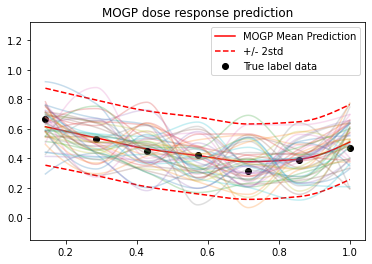

In [12]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Make predictions with the model and plot one of the dose response curves"
"We plot the mean +/- 2std of the MOGP predicitons"
"The multiple coloured functions are samples from predictive posterior distribution"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
N_Samples = 50
Ypred_interp,StdPred_upper_interp,StdPred_lower_interp,Ypred_MOGP_Samples,_,_,_,_ = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose=x_dose,x_dose_new = x_dose_new,model=model,Xval=Xtrain,MOGPsamples=N_Samples)

idx = 0
#for idx in range(20):
plt.figure(idx)
plt.ylim([-0.15,1.32])
plt.plot(x_dose_new,Ypred_interp[idx],'r')
plt.plot(x_dose_new,StdPred_upper_interp[idx],'r--')
plt.plot(x_dose_new,StdPred_lower_interp[idx],'r--')
plt.plot(x_dose, Yall[idx], 'ko')
plt.title('MOGP dose response prediction')
plt.legend(["MOGP Mean Prediction","+/- 2std","_nolegend","True label data"])
for i in range(N_Samples):
    plt.plot(x_dose_new, Ypred_MOGP_Samples[idx][i],alpha=0.25)


In [13]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here We run the KLRelevance algorith over an specific p-th feature"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from importlib import reload
import Utils_SummaryMetrics_KLRelevance as MyUtils
reload(MyUtils)
KLRel = np.zeros((Xtrain.shape[0]//Dnorm_cell,Xtrain.shape[1]-1))
FileName = "Drug"+config.drug_name+"_MelanomaGDSC1_ANOVA_ExactMOGP_m"+m_trained
for pth_feat in range(24):
    relevance = MyUtils.KLRelevance_MOGP_GPy(train_x=Xtrain, model=model, delta=1.0e-6,
                                                       which_p=int(pth_feat), diag=False, Use_Cholesky=True,
                                                       ToSave=False, FileName=FileName)
    KLRel[:,pth_feat] = relevance[:,pth_feat].copy()

Mean_KLRel = np.mean(KLRel,0)[None,:]
Norm_Mean_KLRel = Mean_KLRel/np.max(Mean_KLRel)
Norm_Mean_KLRel_sorted = np.sort(Norm_Mean_KLRel).flatten()[::-1]
ind_sort = np.argsort(Norm_Mean_KLRel)
Names_features_sorted = Name_Features_Melanoma[ind_sort].flatten()[::-1]

Analysing Feature 0 of 24...
Analysing Feature 1 of 24...
Analysing Feature 2 of 24...
Analysing Feature 3 of 24...
Analysing Feature 4 of 24...
Analysing Feature 5 of 24...
Analysing Feature 6 of 24...
Analysing Feature 7 of 24...
Analysing Feature 8 of 24...
Analysing Feature 9 of 24...
Analysing Feature 10 of 24...
Analysing Feature 11 of 24...
Analysing Feature 12 of 24...
Analysing Feature 13 of 24...
Analysing Feature 14 of 24...
Analysing Feature 15 of 24...
Analysing Feature 16 of 24...
Analysing Feature 17 of 24...
Analysing Feature 18 of 24...
Analysing Feature 19 of 24...
Analysing Feature 20 of 24...
Analysing Feature 21 of 24...
Analysing Feature 22 of 24...
Analysing Feature 23 of 24...


In [14]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we just update the names of the genomic features and actual drug names"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
dict_new_names={"BRAF_mut":'BRAF mut',
                "ARID1A_mut":"ARID1A mut",
                "EZH2_mut":"EZH2 mut",
                "MECOM_mut":"MECOM mut",
                "PLCB1_mut":"PLCB1 mut",
                "PTEN_mut":"PTEN mut",
                "NRAS_mut":"NRAS mut",
                "ARID2_mut":"ARID2 mut",
                "TP53_mut":"TP53 mut",
                "NF1_mut":"NF1 mut",
                "CDKN2A_mut":"CDKN2A mut",
                "loss.cnaSKCM3":"loss.cna.chr16q23.1",
                "loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.":"loss.cna.chr9p24.3",
                "loss.cnaSKCM5..PAX5.":"loss.cna.chr9p13.2",
                "loss.cnaSKCM9":"loss.cna.chr17p13.2",
                "gain.cnaSKCM12..KRAS.":"gain.cna.chr12p12.3",
                "gain.cnaSKCM21..FOXP1.MITF.":"gain.cna.chr3p14.1",
                "loss.cnaSKCM22":"loss.cna.chr10q23.31",
                "loss.cnaSKCM23":"loss.cna.chr10q23.33",
                "loss.cnaSKCM24..loss.cnaSKCM25":"loss.cna.chr10q26.3",
                "loss.cnaSKCM26":"loss.cna.chr14q32.2",
                "loss.cnaSKCM27..CASP1.":"loss.cna.chr11q22.3",
                "loss.cnaSKCM28":"loss.cna.chr11q24.2",
                "loss.cnaSKCM30":"loss.cna.chr2q37.3"}


In [15]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a dataframe to plot the KLRelevance ranking"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Names_feat_sorted_updated = [dict_new_names[Name] for Name in Names_features_sorted] #update features names
df_KLRel_GDSC2 = pd.DataFrame({'dataset':['GDSC2']*Norm_Mean_KLRel_sorted.shape[0],
                               'drug_name':Norm_Mean_KLRel_sorted.shape[0]*[dict_drug_name[int(config.drug_name)]],
                               'drug_id':Norm_Mean_KLRel_sorted.shape[0]*[config.drug_name],'feature_name':Names_feat_sorted_updated,
                               'Relevance': Norm_Mean_KLRel_sorted})

In [16]:
df_KLRel_GDSC2['dataset']='KLRelevance'
df_KLRel_GDSC2

,dataset,drug_name,drug_id,feature_name,Relevance
0,KLRelevance,Dabrafenib,1373,ARID1A mut,1.000000
1,KLRelevance,Dabrafenib,1373,loss.cna.chr10q23.31,0.768067
2,KLRelevance,Dabrafenib,1373,EZH2 mut,0.755710
3,KLRelevance,Dabrafenib,1373,PLCB1 mut,0.673608
4,KLRelevance,Dabrafenib,1373,NRAS mut,0.644943
5,KLRelevance,Dabrafenib,1373,MECOM mut,0.560878
6,KLRelevance,Dabrafenib,1373,loss.cna.chr9p24.3,0.525602
7,KLRelevance,Dabrafenib,1373,loss.cna.chr11q24.2,0.509705
8,KLRelevance,Dabrafenib,1373,BRAF mut,0.480437
9,KLRelevance,Dabrafenib,1373,PTEN mut,0.380873


# Plot rankings obtained with KL-Relevance, SHAP and ANOVA for GDSC2
In order to run this section we have to compute the SHAP ranking using the mean prediction from the MOGP model. The covariance prediction of the MOGP is negglected since SHAP only expects a point estimate.

Permutation explainer: 330it [02:05,  2.44it/s]                                 


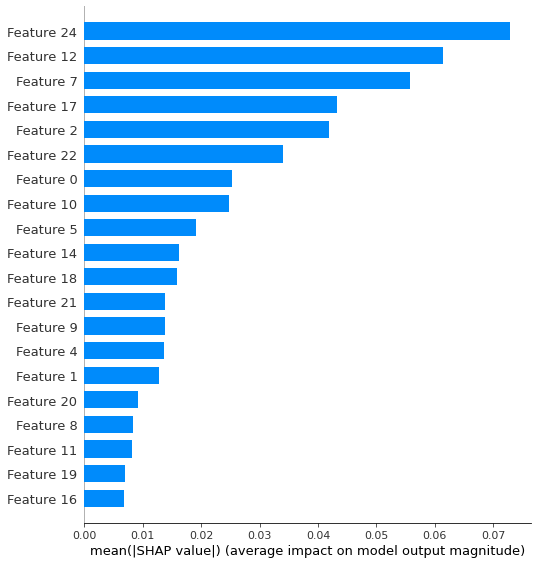

In [17]:
"""Here we compute the SHAP relevance with our mean MOGP prediction"""

import shap
'The mpred function is to extract only the mean prediction'
'and neglet the covariance prediciton'
def mpred(X):
    m_pred, v_pred = model.predict(X)
    return m_pred.flatten()

explainer = shap.Explainer(mpred,Xtrain)
shap_values = explainer(Xtrain)

# visualize the first prediction's explanation
shap.summary_plot(shap_values, Xtrain, plot_type='bar')

In [18]:
shap_values[0]

.values =
array([-0.014804  , -0.00551334, -0.0198932 , -0.0029851 , -0.00525375,
       -0.0129424 , -0.00074817, -0.02387918,  0.        , -0.00794866,
       -0.08323217,  0.00258446,  0.11252544,  0.00134793,  0.0077489 ,
        0.00266539, -0.0165772 , -0.03426361,  0.00784302, -0.00327852,
        0.00595867, -0.00759571, -0.02346235,  0.00051128,  0.1445205 ])

.base_values =
0.5911014521684863

.data =
array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0.])

<BarContainer object of 24 artists>

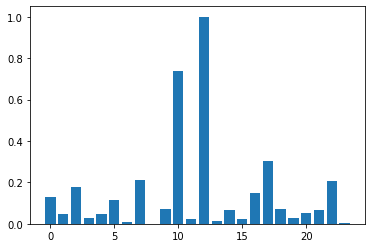

In [19]:
"Here we normilised the values to be between 0 and 1"

SHAP_Rel_raw = shap_values[0].values[0:-1]
SHAP_Rel_norm = np.abs(SHAP_Rel_raw)/np.abs(SHAP_Rel_raw).max() 
plt.bar(np.arange(0,24),SHAP_Rel_norm)

In [20]:
"""Sort the features by ranking relevance"""

ind_sort_shap = np.argsort(SHAP_Rel_norm)
SHAP_Names_feat_sorted = Name_Features_Melanoma[ind_sort_shap][::-1]
SHAP_Rel_norm_sorted = SHAP_Rel_norm[ind_sort_shap][::-1]

In [21]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a dataframe to plot the SHAP ranking"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
SHAP_Names_feat_sorted_updated = [dict_new_names[Name] for Name in SHAP_Names_feat_sorted] #update features names
df_SHAP_GDSC2 = pd.DataFrame({'dataset':['SHAP']*SHAP_Rel_norm.shape[0],
                               'drug_name':SHAP_Rel_norm.shape[0]*[dict_drug_name[int(config.drug_name)]],
                               'drug_id':SHAP_Rel_norm.shape[0]*[config.drug_name],'feature_name':SHAP_Names_feat_sorted_updated,
                               'Relevance': SHAP_Rel_norm_sorted})
df_SHAP_GDSC2

,dataset,drug_name,drug_id,feature_name,Relevance
0,SHAP,Dabrafenib,1373,loss.cna.chr9p24.3,1.000000
1,SHAP,Dabrafenib,1373,TP53 mut,0.739674
2,SHAP,Dabrafenib,1373,loss.cna.chr10q23.31,0.304497
3,SHAP,Dabrafenib,1373,NRAS mut,0.212211
4,SHAP,Dabrafenib,1373,loss.cna.chr11q24.2,0.208507
5,SHAP,Dabrafenib,1373,BRAF mut,0.176788
6,SHAP,Dabrafenib,1373,gain.cna.chr3p14.1,0.147320
7,SHAP,Dabrafenib,1373,ARID1A mut,0.131561
8,SHAP,Dabrafenib,1373,MECOM mut,0.115018
9,SHAP,Dabrafenib,1373,PTEN mut,0.070639


In [22]:
SHAP_Names_feat_sorted

Index(['loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.', 'TP53_mut', 'loss.cnaSKCM22',
       'NRAS_mut', 'loss.cnaSKCM28', 'BRAF_mut', 'gain.cnaSKCM21..FOXP1.MITF.',
       'ARID1A_mut', 'MECOM_mut', 'PTEN_mut', 'loss.cnaSKCM23',
       'loss.cnaSKCM9', 'loss.cnaSKCM27..CASP1.', 'loss.cnaSKCM26',
       'ARID2_mut', 'EZH2_mut', 'loss.cnaSKCM24..loss.cnaSKCM25', 'CDKN2A_mut',
       'gain.cnaSKCM12..KRAS.', 'loss.cnaSKCM3', 'loss.cnaSKCM5..PAX5.',
       'NF1_mut', 'loss.cnaSKCM30', 'PLCB1_mut'],
      dtype='object')

In [23]:
"""Load the ANOVA ranking that was computed in the study of GDSC1 and GDSC2"""

df_ANOVA = pd.read_csv('ANOVA_KL_relevance_BRAF_3drugs.csv')
#df_ANOVA = pd.read_csv('ANOVA_and_KLRel_values.csv')

In [24]:
"""Select just the data for GDSC2"""

df_ANOVA_GDSC2 = df_ANOVA[df_ANOVA['dataset']=='GDSC2']
df_ANOVA_GDSC2 = df_ANOVA_GDSC2[df_ANOVA_GDSC2['drug_id']==int(config.drug_name)]
df_ANOVA_GDSC2

,dataset,drug_name,drug_id,feature_name,feature_pval,KL_relevance
24,GDSC2,Dabrafenib,1373,CDKN2A_mut,0.014693,0.176345
25,GDSC2,Dabrafenib,1373,NRAS_mut,0.000383,0.644946
26,GDSC2,Dabrafenib,1373,BRAF_mut,0.000001,0.480460
27,GDSC2,Dabrafenib,1373,loss.cnaSKCM3,0.226650,0.197861
28,GDSC2,Dabrafenib,1373,ARID2_mut,0.055338,0.345914
29,GDSC2,Dabrafenib,1373,TP53_mut,0.180511,0.215648
30,GDSC2,Dabrafenib,1373,loss.cnaSKCM24..loss.cnaSKCM25,0.603708,0.205405
31,GDSC2,Dabrafenib,1373,PLCB1_mut,0.103909,0.673584
32,GDSC2,Dabrafenib,1373,NF1_mut,0.054369,0.184986
33,GDSC2,Dabrafenib,1373,MECOM_mut,NaN,0.560858


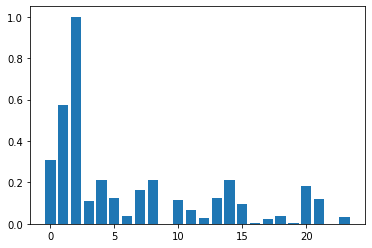

In [25]:
"Here we normilised the values to be between 0 and 1"

ANOVA_Rel_norm = (df_ANOVA_GDSC2['feature_pval'].values)
ANOVA_Rel_norm = -np.log10(ANOVA_Rel_norm)
idx_nan = np.where(np.isnan(ANOVA_Rel_norm))[0]
ANOVA_Rel_norm[idx_nan] = 0.0  #This position is a NaN so we just assume not relevance here
ANOVA_Rel_norm = ANOVA_Rel_norm/ANOVA_Rel_norm.max()
plt.bar(np.arange(0,24),ANOVA_Rel_norm)
Name_Features_ANOVA = df_ANOVA_GDSC2['feature_name'].values

In [26]:
ANOVA_Rel_norm

array([0.30820643, 0.5746402 , 1.        , 0.10839982, 0.21136576,
       0.12502189, 0.03685488, 0.16535408, 0.21265583, 0.        ,
       0.11439471, 0.0663017 , 0.02949946, 0.12354691, 0.21028825,
       0.09772981, 0.00547508, 0.0239393 , 0.03907175, 0.00580155,
       0.18226658, 0.1217653 , 0.        , 0.03286279])

In [27]:
"""Sort the features by ranking relevance"""

ind_sort_anova = np.argsort(ANOVA_Rel_norm)
ANOVA_Names_feat_sorted = Name_Features_ANOVA[ind_sort_anova][::-1]
ANOVA_Rel_norm_sorted = ANOVA_Rel_norm[ind_sort_anova][::-1]

In [28]:
ANOVA_Names_feat_sorted

array(['BRAF_mut', 'NRAS_mut', 'CDKN2A_mut', 'NF1_mut', 'ARID2_mut',
       'loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.', 'loss.cnaSKCM28',
       'PLCB1_mut', 'TP53_mut', 'loss.cnaSKCM30', 'loss.cnaSKCM23',
       'loss.cnaSKCM27..CASP1.', 'loss.cnaSKCM3', 'loss.cnaSKCM22',
       'gain.cnaSKCM12..KRAS.', 'gain.cnaSKCM21..FOXP1.MITF.',
       'loss.cnaSKCM24..loss.cnaSKCM25', 'loss.cnaSKCM9', 'EZH2_mut',
       'loss.cnaSKCM26', 'loss.cnaSKCM5..PAX5.', 'PTEN_mut', 'MECOM_mut',
       'ARID1A_mut'], dtype=object)

In [29]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a dataframe to plot the ANOVA ranking"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
ANOVA_Names_feat_sorted_updated = [dict_new_names[Name] for Name in ANOVA_Names_feat_sorted] #update features names
df_ANOVA_GDSC2_final = pd.DataFrame({'dataset':['ANOVA']*ANOVA_Rel_norm.shape[0],
                               'drug_name':ANOVA_Rel_norm.shape[0]*[dict_drug_name[int(config.drug_name)]],
                               'drug_id':ANOVA_Rel_norm.shape[0]*[config.drug_name],'feature_name':ANOVA_Names_feat_sorted_updated,
                               'Relevance': ANOVA_Rel_norm_sorted})
df_ANOVA_GDSC2_final

,dataset,drug_name,drug_id,feature_name,Relevance
0,ANOVA,Dabrafenib,1373,BRAF mut,1.000000
1,ANOVA,Dabrafenib,1373,NRAS mut,0.574640
2,ANOVA,Dabrafenib,1373,CDKN2A mut,0.308206
3,ANOVA,Dabrafenib,1373,NF1 mut,0.212656
4,ANOVA,Dabrafenib,1373,ARID2 mut,0.211366
5,ANOVA,Dabrafenib,1373,loss.cna.chr9p24.3,0.210288
6,ANOVA,Dabrafenib,1373,loss.cna.chr11q24.2,0.182267
7,ANOVA,Dabrafenib,1373,PLCB1 mut,0.165354
8,ANOVA,Dabrafenib,1373,TP53 mut,0.125022
9,ANOVA,Dabrafenib,1373,loss.cna.chr2q37.3,0.123547


In [30]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Concatenate KLRelevance, SHAP and ANOVA methods in the same data frame to plot Fig. 2 that appears in Supplementary" 
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
df_KLRel_GDSC1_and_GDSC2 = pd.concat([df_KLRel_GDSC2.sort_values(by='Relevance', ascending=True),df_SHAP_GDSC2.sort_values(by='Relevance', ascending=True),df_ANOVA_GDSC2_final.sort_values(by='Relevance', ascending=True)])
#df_KLRel_GDSC1_and_GDSC2

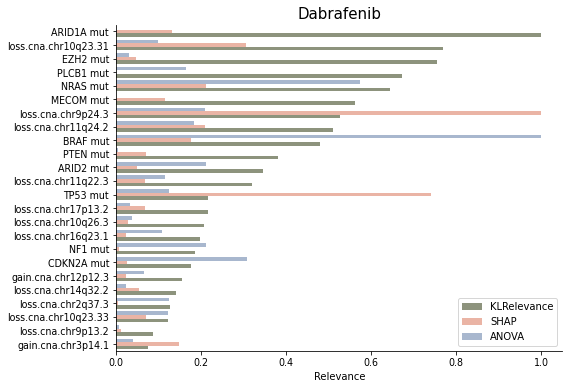

In [31]:
import seaborn as sns

# Create the plot
plt.figure(figsize=(8, 6))

sns.barplot(
    data=df_KLRel_GDSC1_and_GDSC2,
    x='Relevance',
    y='feature_name',
    hue='dataset',
    palette=[ '#8F9779', '#F6AE99','#A2B6D4'],
    dodge=True,  # This separates bars based on hue
    hue_order=['KLRelevance','SHAP','ANOVA']  # This ensures GDSC2 appears first, then GDSC1
)

plt.xlabel('Relevance')
plt.ylabel('')
plt.title('')
plt.xticks(size=9.5)
plt.yticks(size=9.5)
plt.gca().invert_yaxis()

# Adjusting legend position and order
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='lower right', title=None)
plt.title(f'{dict_drug_name[int(config.drug_name)]}',fontsize=15)
sns.despine()
#plt.show()
plt.savefig('KLRel_ANOVA_and_SHAP_Comparison_'+(dict_drug_name[int(config.drug_name)])+'.pdf',bbox_inches='tight')

In [32]:
"Here we just print the name of the drugs that was analysed. We can change config.drug_name at the beginning"
"of the notebook to 1036 (PLX-4720), 1061 (SB590885) or 1373 (Dabrafenib)"

dict_drug_name[int(config.drug_name)]

'Dabrafenib'